In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm
import os

# 기본 한글 폰트 설정 (시각화 한글 깨짐 방지)
plt.rcParams['font.family'] = 'Malgun Gothic'
# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

CAPTURE_DIR = "./captures"
os.makedirs(CAPTURE_DIR, exist_ok=True)

In [2]:
df = pd.read_csv("./data/working/tpss_bcycl_od_statnhm_202406_통합_w_자치구.csv")

In [3]:
df.head()

,기준_날짜,집계_기준,기준_시간대,시작_대여소_ID,시작_대여소명,시작_대여소_자치구,종료_대여소_ID,종료_대여소명,종료_대여소_자치구,전체_건수,전체_이용_분,전체_이용_거리
0,20240601,출발시간,0,ST-1002,목1동_004_1,양천구,ST-1017,목5동_059_1,양천구,1,8.0,870.0
1,20240601,출발시간,0,ST-1015,목5동_001_1,양천구,ST-997,목4동_021_1,양천구,1,10.0,1552.0
2,20240601,출발시간,0,ST-1036,역촌동_001_1,은평구,ST-1035,불광2동_021_1,은평구,1,42.0,4980.0
3,20240601,출발시간,0,ST-1045,성내2동_007_1,강동구,ST-1580,오륜동_001_3,송파구,1,8.0,1923.0
4,20240601,출발시간,0,ST-1047,성내1동_023_1,강동구,ST-488,암사1동_044_1,강동구,1,18.0,3530.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8831528 entries, 0 to 8831527
Data columns (total 12 columns):
 #   Column      Dtype  
---  ------      -----  
 0   기준_날짜       int64  
 1   집계_기준       object 
 2   기준_시간대      int64  
 3   시작_대여소_ID   object 
 4   시작_대여소명     object 
 5   시작_대여소_자치구  object 
 6   종료_대여소_ID   object 
 7   종료_대여소명     object 
 8   종료_대여소_자치구  object 
 9   전체_건수       int64  
 10  전체_이용_분     float64
 11  전체_이용_거리    float64
dtypes: float64(2), int64(3), object(7)
memory usage: 808.6+ MB


In [9]:
df.shape

(8831528, 12)

In [11]:
# 이용량 파악을 위해서 집계_기준 == 출발시간만 추출
df = df[df["집계_기준"] == "출발시간"]

In [12]:
df.shape

(4428007, 12)

In [15]:
# 기준_시간대가 5분 단위로 집계됨
df["기준_시간대"].unique()

array([   0,    5,   10,   15,   20,   25,   30,   35,   40,   45,   50,
         55,  100,  105,  110,  115,  120,  125,  130,  135,  140,  145,
        150,  155,  200,  205,  210,  215,  220,  225,  230,  235,  240,
        245,  250,  255,  300,  305,  310,  315,  320,  325,  330,  335,
        340,  345,  350,  355,  400,  405,  410,  415,  420,  425,  430,
        435,  440,  445,  450,  455,  500,  505,  510,  515,  520,  525,
        530,  535,  540,  545,  550,  555,  600,  605,  610,  615,  620,
        625,  630,  635,  640,  645,  650,  655,  700,  705,  710,  715,
        720,  725,  730,  735,  740,  745,  750,  755,  800,  805,  810,
        815,  820,  825,  830,  835,  840,  845,  850,  855,  900,  905,
        910,  915,  920,  925,  930,  935,  940,  945,  950,  955, 1000,
       1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055,
       1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150,
       1155, 1200, 1205, 1210, 1215, 1220, 1225, 12

# 시간대 별로 그룹화

- 시간대를 1시간 단위로 그룹화 해서 1시간 마다의 이용량을 구함

In [18]:
df["기준_월"] = "202406"

# 숫자형
df["전체_건수"]   = pd.to_numeric(df["전체_건수"], errors="coerce").fillna(0).astype(int)
df["기준_시간대"] = pd.to_numeric(df["기준_시간대"], errors="coerce").fillna(0).astype(int)

# 기준_시간대_1시간 (0~23)
df["기준_시간대_1시간"] = df["기준_시간대"] // 100
df["기준_시간대_1시간"] = df["기준_시간대_1시간"].clip(0, 23)

# 출발 > 시작_대여소_자치구, 도착 > 종료_대여소_자치구
df["자치구"] = df["시작_대여소_자치구"]

# 자치구 × 1시간 × 집계기준 그룹화
grouped = (
    df.groupby(["기준_월", "기준_시간대_1시간", "자치구"], as_index=False)["전체_건수"]
      .sum()
      .sort_values(["기준_월", "기준_시간대_1시간", "자치구"])
)

In [19]:
grouped.head()

,기준_월,기준_시간대_1시간,자치구,전체_건수
0,202406,0,강남구,3369
1,202406,0,강동구,4983
2,202406,0,강북구,2177
3,202406,0,강서구,9125
4,202406,0,관악구,3450


In [22]:
# 시간대가 (0 ~ 23)으로 나오는지 확인
grouped["기준_시간대_1시간"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [24]:
# 자치구가 누락된 값이 있는지 확인
grouped["자치구"].unique()

array(['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구',
       '도봉구', '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구',
       '양천구', '영등포구', '용산구', '은평구', '종로구', '중구', '중랑구'], dtype=object)

In [26]:
grouped["자치구"].nunique()

25

In [28]:
# 자치구로 별로 분리 되어있는 것을 1시간 단위로 다시 그룹화
time_grouped = grouped.groupby("기준_시간대_1시간")["전체_건수"].sum().reset_index()

In [30]:
time_grouped.head()

,기준_시간대_1시간,전체_건수
0,0,102694
1,1,68551
2,2,45583
3,3,31170
4,4,25950


In [32]:
# 데이터 누락 확인
time_grouped["전체_건수"].sum() == grouped["전체_건수"].sum()

True

In [34]:
# 전체 건수의 평균값을 구함
time_grouped["전체_건수"].mean()

196256.125

# 이용량 시각화
- 기준 시간대 별로 이용량이 얼마나 되는지 눈으로 쉽게 파악하기 위해서 시각화함
- 시각화를 통해 활성 시간, 비활성 시간을 구함

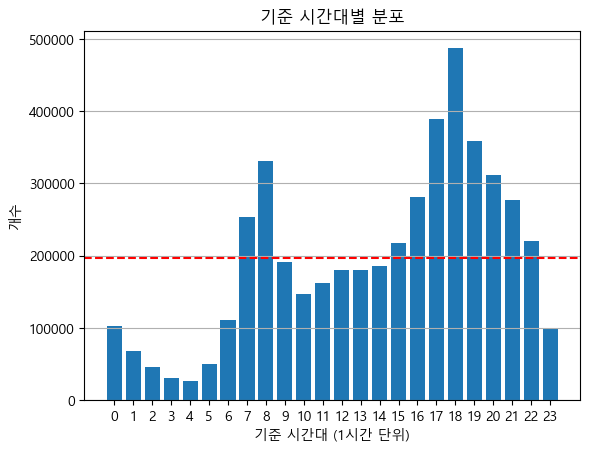

In [39]:
# 평균
counts = time_grouped.groupby("기준_시간대_1시간")["전체_건수"].sum()
means = time_grouped["전체_건수"].mean()

plt.figure()
plt.bar(counts.index, counts.values)

plt.axhline(y = means, color = "red", linestyle = "--")

plt.title("기준 시간대별 분포")
plt.xlabel("기준 시간대 (1시간 단위)")
plt.ylabel("개수")

plt.xticks(range(0, 24))
plt.grid(axis="y")
plt.savefig(os.path.join(CAPTURE_DIR, "03_Activation_Time_Mean.png"), dpi=300)

plt.show()

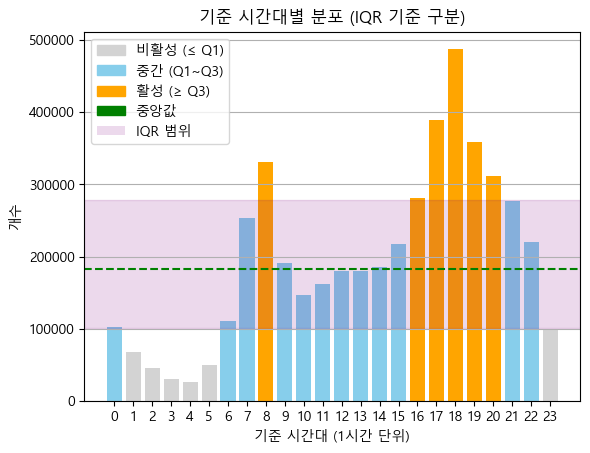

In [41]:
# 중앙값 + 사분위수
counts = time_grouped.groupby("기준_시간대_1시간")["전체_건수"].sum()

# 중앙값, 사분위수 계산
median = counts.median()
q1 = counts.quantile(0.25)
q3 = counts.quantile(0.75)

plt.figure()

# 시간대별 색상 구분
colors = []
for val in counts.values:
    if val <= q1:
        colors.append("lightgray")   # 비활성
    elif val >= q3:
        colors.append("orange")      # 활성
    else:
        colors.append("skyblue")     # 중간

plt.bar(counts.index, counts.values, color=colors)

# 중앙값 선
plt.axhline(y=median, color="green", linestyle="--", label=f"중앙값 ({median:.0f})")

# IQR 범위 음영
plt.axhspan(q1, q3, color="purple", alpha=0.15, label=f"IQR ({q1:.0f}~{q3:.0f})")

plt.title("기준 시간대별 분포 (IQR 기준 구분)")
plt.xlabel("기준 시간대 (1시간 단위)")
plt.ylabel("개수")

plt.xticks(range(0, 24))
plt.grid(axis="y")

# 범례 수동 추가
from matplotlib.patches import Patch
legend_handles = [
    Patch(color="lightgray", label="비활성 (≤ Q1)"),
    Patch(color="skyblue", label="중간 (Q1~Q3)"),
    Patch(color="orange", label="활성 (≥ Q3)"),
    Patch(color="green", label="중앙값"),
    Patch(facecolor="purple", alpha=0.15, label="IQR 범위")
]
plt.legend(handles=legend_handles)
plt.savefig(os.path.join(CAPTURE_DIR, "03_Activation_Time_IQR.png"), dpi=300)

plt.show()